In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import minimize
plt.style.use('../notebooks/style.mpl')

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Respiratory heterotrophy model

# Mapping $S_1$ and $S_6$ using $Z_{C,red}$

We have the following equations:

\begin{align}
S_1 =  \frac{1}{2} (Z_{C,ox} - Z_{C,red}) \\
S_6 = \frac{1}{2} (Z_{C,B} - Z_{C,red}) \\
\end{align}

We want to vary $Z_{C,red}$ and effectively set $S_1$ and $S_6$ from it.

In [3]:
ZCred = 0.0 # setting a dummy ZCred, assuming glucose as a reference carbon source
ZCox = +4.0 # assuming CO2 as the reference metabolic product
ZCB = 0.0   # assuming glucose as reference carbon source, and reference S6 of 0

def set_stoichs(ZCox, ZCB, ZCred):
    S1 = 0.5 * (ZCox - ZCred)
    S6 = 0.5 * (ZCB - ZCred)
    return S1, S6

In [4]:
S1, S6 = set_stoichs(ZCox, ZCB, ZCred)

In [5]:
S1, S6

(2.0, 0.0)

# Respiratory heterotrophy model

In [6]:
eps = 1e-10
tau = 1e0
S2 = 2.

In [7]:
rho  = 1.0
qMc = 12.0

In [8]:
def het_model( t, y ):
    x = y.copy()
    x[x<eps] = eps
    x[x>1e8] = 1e8
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]
    
    NAD = r1 * NADH
    ADP = r2 * ATP

    # concentration dynamics are in χ units; NADH and ATP take values in mol/gC
    # where 1 mM = 1e-3 mol/l = 6e-6 mol/gC
    N_KM = NADH/KM
    A_KM = ATP/KM
    
    # Writing down the MM term for NADH and ATP explicitly.
    fN = N_KM / (1 + N_KM)
    fA = A_KM / (1 + A_KM)

    nu_cat = rho * phi_cat * gamma_cat_inv * tau
    nu_resp = rho * phi_resp * gamma_resp_inv * tau
    nu_ana = rho * phi_ana * gamma_ana_inv * tau
    
    mu = qMc * nu_ana
    Jh = rho * phi_h * gamma_hom_inv * tau
    
    # dCorg = - nu_cat - nu_ana + nu_supply - mu * Corg
    dCorg = 0.0
    dNADH = S1 * nu_cat - S2 * nu_resp - S6 * nu_ana - mu * (NADH + NAD)
    # dNADH = 0.0
    dNAD = - dNADH
    dO2 = 0.0
    dATP = S3 * nu_cat + S4 * nu_resp - S5 * nu_ana  - Jh - maint - mu * ATP
    dADP = -dATP
    
    dydt = np.array([dCorg, dNADH, dO2, dATP])
    return dydt

### Parameters

In [9]:
# gamma inverses are in /hr units.
gamma_cat_inv = 5e-5*3600
gamma_resp_inv = 5e-5*3600
gamma_ana_inv = 5e-5*3600
gamma_hom_inv = 5e-5*3600

phi_cat = 0.3
phi_ana = 0.4
phi_resp = 0.03
phi_h = 0.0
phi_o = 1 - (phi_cat + phi_ana + phi_resp + phi_h)

# maintenance energy
maint = 0.01

# Default params: reliance on respiration.
S4 = 1.0    # ATP yield of respiration
S3 = 0.5    # ATP yield of catabolism
S5 = 0.3    # ATP cost of anabolism

### Initial conditions

In [10]:
# concentrations in χ units; initial values set arbitarily.
Corg0 = 1e2
NADH0 = 1e2
O20 = 1e1
ATP0 = 1e2

# KM is in χ units, mol/gC (new supplement section 2.1: typical χ values)
KM = 6e-7   # 1e-3 mol/L is 6e-6 mol/gC; 6e-7 is thus for a KM of 100 μM.
r1 = 10.
r2 = 0.1

In [11]:
# Constraint function for dNADH = 0 and dATP = 0 based on het_model
def new_constraints(x):
    NADH = x[5]
    ATP = x[4]
    NAD = r1 * NADH
    ADP = r2 * ATP
    N_KM = NADH / KM
    A_KM = ATP / KM
    fN = N_KM / (1 + N_KM)
    fA = A_KM / (1 + A_KM)
    nu_cat = rho * x[0] * gamma_cat_inv * tau
    nu_resp = rho * x[1] * gamma_resp_inv * tau
    nu_ana = rho * x[2] * gamma_ana_inv * tau
    mu = qMc * nu_ana
    Jh = rho * x[3] * gamma_hom_inv * tau
    dNADH = S1 * nu_cat - S2 * nu_resp - S6 * nu_ana - mu * (NADH + NAD)
    dATP = S3 * nu_cat + S4 * nu_resp - S5 * nu_ana - Jh - maint - mu * ATP
    return [dNADH, dATP]

In [12]:
# Set fixed values for phi_o_min and maintenance
MIN_PHI_O = 0.3
maint = 0.00

LB_CONC = 1e-8  # threshold concentration set to arbitrary small value
UB_CONC = 1e-2   # threshold concentration set to reasonable value

# Initial guess for the phi variables and metabolite concentrations
initial_values = [0.1, 0.1, 0.1, 0.1, 1e2, 1e2, 0.5]  # Update as necessary. The last two are ATP and NADH

# Bounds for the phi variables and metabolite concentrations.
bounds = [(0, 1), (0, 1), (0, 1), (0, 1), 
          (LB_CONC, UB_CONC), (LB_CONC, UB_CONC),
          (MIN_PHI_O, 1)]

# Constraint function for the sum of phi parameters and the dNADH and dATP = 0 conditions
cons = ({'type': 'eq', 'fun': lambda x: sum(x[:-3]) - (1 - x[-1])},
        {'type': 'eq', 'fun': lambda x: new_constraints(x)[0]},
        {'type': 'eq', 'fun': lambda x: new_constraints(x)[1]})

# Objective function. 
def growth_rate_obj(phi_values):
    phi_cat, phi_resp, phi_ana, phi_h, A, N, phi_o = phi_values

    # Objective function for optimization
    # obj needs to be minimized, so we set it to 
    # the negative of the growth rate.
    obj = - qMc * rho * phi_ana * gamma_ana_inv * tau

    return obj

# Call the optimizer
res = minimize(growth_rate_obj, initial_values, method='SLSQP', bounds=bounds, constraints=cons)

# Extract the optimal phi values and metabolite concentrations
phi_cat_opt, phi_resp_opt, phi_ana_opt, phi_h_opt, ATP_opt, NADH_opt, phi_o_opt = res.x

print('Chosen phi_o:', phi_o_opt)
print('Optimal phi_cat:', phi_cat_opt)
print('Optimal phi_resp:', phi_resp_opt)
print('Optimal phi_ana:', phi_ana_opt)
print('Optimal phi_h:', phi_h_opt)
print('Optimal ATP:', ATP_opt)
print('Optimal NADH:', NADH_opt)
print('Optimal growth rate:', -growth_rate_obj(res.x))


Chosen phi_o: 0.3000000000000074
Optimal phi_cat: 0.10000023304185596
Optimal phi_resp: 0.09999990281252624
Optimal phi_ana: 0.49999986414560993
Optimal phi_h: 3.5388358909926865e-16
Optimal ATP: 1.0000001387719393e-08
Optimal NADH: 1e-08
Optimal growth rate: 1.0799997065545175


Checking if all constraints are satisfied

In [13]:
print('Allocation constraint satisfied:', np.isclose(cons[0]['fun'](res.x), 0, atol=1e-8))
print('NADH balanced:', np.isclose(cons[1]['fun'](res.x), 0, atol=1e-8))
print('ATP balanced:', np.isclose(cons[2]['fun'](res.x), 0, atol=1e-8))

Allocation constraint satisfied: True
NADH balanced: True
ATP balanced: True


In [14]:
-res.fun

1.0799997065545175

# Varying $Z_{C,red}$

In [31]:
SAMPLING_DENSITY = 25

# Set fixed values for phi_o_min and maintenance
MIN_PHI_O = 0.6
maint = 0.00

# Old defaults.
# ATP_LB_CONC = 1e-8
# ATP_UB_CONC = 1e-2
# NADH_LB_CONC = 1e-8
# NADH_UB_CONC = 1e-2

# Avi's suggested values; these make the MM for ATP irrelevant.
ATP_LB_CONC = 6e-6
ATP_UB_CONC = 6e-5
NADH_LB_CONC = 6e-7
NADH_UB_CONC = 1.2e-6

# Initial guess for the phi variables and metabolite concentrations
initial_values = [0.1, 0.1, 0.1, 0.1, 1e2, 1e2, 0.5]  # Update as necessary. The last two are ATP and NADH

# Bounds for the phi variables and metabolite concentrations.
bounds = [(0, 1), (0, 1), (0, 1), (0, 0), 
          (ATP_LB_CONC, ATP_UB_CONC), (NADH_LB_CONC, NADH_UB_CONC),
          (MIN_PHI_O, 1)]

opt_atps = []
opt_nadhs = []
opt_mus = []
opt_phi_cats = []
opt_phi_resps = []
opt_phi_anas = []
opt_phi_hs = []
opt_phi_os = []
zcreds = []
zcbs = []
s6s = []
s4s = []
s3s = []

S4 = 1.0    # ATP yield of respiration
S3 = 0.5    # ATP yield of catabolism
for S4 in [1.0, 0.1]:
    for S3 in [0.5, 0.1]:
        for ZCred in np.linspace(-5, 10, 50):
            # setting stoichiometries
            S1, S6 = set_stoichs(ZCox, ZCB, ZCred)

            # Constraint function for the sum of phi parameters and the dNADH and dATP = 0 conditions
            cons = ({'type': 'eq', 'fun': lambda x: sum(x[:-3]) - (1 - x[-1])},
                    {'type': 'eq', 'fun': lambda x: new_constraints(x)[0]},
                    {'type': 'eq', 'fun': lambda x: new_constraints(x)[1]})

            # Objective function. 
            def growth_rate_obj(phi_values):
                phi_cat, phi_resp, phi_ana, phi_h, A, N, phi_o = phi_values

                # Objective function for optimization
                # obj needs to be minimized, so we set it to 
                # the negative of the growth rate.
                obj = - qMc * rho * phi_ana * gamma_ana_inv * tau

                return obj

            # Call the optimizer
            res = minimize(growth_rate_obj, initial_values, method='SLSQP', bounds=bounds, constraints=cons)

            # Extract the optimal phi values and metabolite concentrations
            phi_cat_opt, phi_resp_opt, phi_ana_opt, phi_h_opt, ATP_opt, NADH_opt, phi_o_opt = res.x

            # storing optimized ATP*, NADH* and optimal phi_resp.
            opt_atps.append(ATP_opt)
            opt_nadhs.append(NADH_opt)
            opt_phi_cats.append(phi_cat_opt)
            opt_phi_resps.append(phi_resp_opt)
            opt_phi_anas.append(phi_ana_opt)
            opt_phi_hs.append(phi_h_opt)
            opt_phi_os.append(phi_o_opt)
            opt_mus.append(-res.fun)
            zcreds.append(ZCred)
            zcbs.append(ZCB)
            s6s.append(S6)
            s4s.append(S4)
            s3s.append(S3)

df = pd.DataFrame({
    'atps': opt_atps,
    'nadhs': opt_nadhs,
    'zcred': zcreds,
    'zcb': zcbs,
    's6s': s6s,
    's4s': s4s,
    's3s': s3s,
    'mus': opt_mus,
    'opt_phi_cat': opt_phi_cats,
    'opt_phi_resp': opt_phi_resps,
    'opt_phi_ana': opt_phi_anas,
    'opt_phi_h': opt_phi_hs,
    'opt_phi_o': opt_phi_os
    })

In [32]:
df

,atps,nadhs,zcred,zcb,s6s,s4s,s3s,mus,opt_phi_cat,opt_phi_resp,opt_phi_ana,opt_phi_h,opt_phi_o
0,0.000006,6.000000e-07,-5.000000,0.0,2.500000,1.0,0.5,5.461750e-01,1.425307e-01,4.610508e-03,2.528588e-01,0.0,0.6
1,0.000006,6.000000e-07,-4.693878,0.0,2.346939,1.0,0.5,5.483398e-01,1.399248e-01,6.214164e-03,2.538610e-01,0.0,0.6
2,0.000006,6.000000e-07,-4.387755,0.0,2.193878,1.0,0.5,5.506509e-01,1.371428e-01,7.926255e-03,2.549310e-01,0.0,0.6
3,0.000006,6.000000e-07,-4.081633,0.0,2.040816,1.0,0.5,5.531237e-01,1.341660e-01,9.758163e-03,2.560758e-01,0.0,0.6
4,0.000006,6.000000e-07,-3.775510,0.0,1.887755,1.0,0.5,5.557759e-01,1.309734e-01,1.172292e-02,2.573037e-01,0.0,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.000006,6.000001e-07,8.775510,0.0,-4.387755,0.1,0.1,1.765307e-15,0.000000e+00,0.000000e+00,8.172716e-16,0.0,1.0
196,0.000006,6.019340e-07,9.081633,0.0,-4.540816,0.1,0.1,1.066241e-10,1.027825e-16,0.000000e+00,4.936299e-11,0.0,1.0
197,0.000006,6.000001e-07,9.387755,0.0,-4.693878,0.1,0.1,2.073498e-15,0.000000e+00,0.000000e+00,9.599526e-16,0.0,1.0
198,0.000006,6.000001e-07,9.693878,0.0,-4.846939,0.1,0.1,2.140475e-15,8.088148e-17,0.000000e+00,9.909608e-16,0.0,1.0


## Changing $S_3$

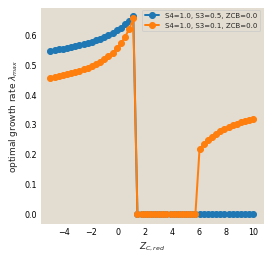

In [33]:
# Initialize the plot
plt.figure(figsize=(4, 4))

# Define the values you want to filter by
s4s_values = [1.0, 1.0]  # Replace with the actual values
s3s_values = [0.5, 0.1]  # Replace with the actual values
zcb_values = [0.0, 0.0]  # Replace with the actual values

# Loop through the values and plot
for s4s_val, s3s_val, zcb_val in zip(s4s_values, s3s_values, zcb_values):
    # Filter the DataFrame
    filtered_df = df[(df['s4s'] == s4s_val) & (df['s3s'] == s3s_val) & (df['zcb'] == zcb_val)]
    
    # Plot the filtered data
    plt.plot(filtered_df['zcred'], filtered_df['mus'], marker='o', linestyle='-', label=f'S4={s4s_val}, S3={s3s_val}, ZCB={zcb_val}')

# Add labels and title
plt.xlabel(r'$Z_{C,red}$')
plt.ylabel('optimal growth rate ' + r'$\lambda_{max}$')

# Add grid and legend
plt.legend()

# Show the plot
plt.show()

## Changing $S_4$

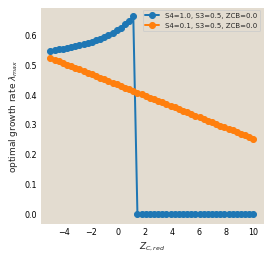

In [34]:
# Initialize the plot
plt.figure(figsize=(4, 4))

# Define the values you want to filter by
s4s_values = [1.0, 0.1]  # Replace with the actual values
s3s_values = [0.5, 0.5]  # Replace with the actual values
zcb_values = [0.0, 0.0]  # Replace with the actual values

# Loop through the values and plot
for s4s_val, s3s_val, zcb_val in zip(s4s_values, s3s_values, zcb_values):
    # Filter the DataFrame
    filtered_df = df[(df['s4s'] == s4s_val) & (df['s3s'] == s3s_val) & (df['zcb'] == zcb_val)]
    
    # Plot the filtered data
    plt.plot(filtered_df['zcred'], filtered_df['mus'], marker='o', linestyle='-', label=f'S4={s4s_val}, S3={s3s_val}, ZCB={zcb_val}')

# Add labels and title
plt.xlabel(r'$Z_{C,red}$')
plt.ylabel('optimal growth rate ' + r'$\lambda_{max}$')

# Add grid and legend
plt.legend()

# Show the plot
plt.show()

# Visually consistent plots

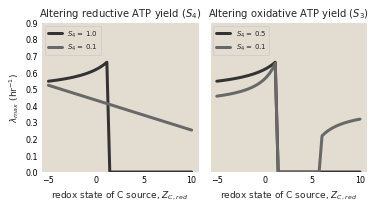

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt

colors = viz.plotting_style()
lin_colors = colors.values()
plt.style.use('style.mpl')

color_order = ['green', 'blue', 'red', 'purple', 'yellow', 'dark_green', 'dark_blue', 'dark_brown']
lin_colors = [colors[c] for c in color_order]

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(5.3, 3), sharey=True)
pal = sns.color_palette('Greys_r', n_colors=5)

# PANEL Α
# Variable S4 = respiratory ATP yield
plt.sca(axs[0])
plt.title('Altering reductive ATP yield ($S_4$)')

# Choosing parameter values.
s4s_values = [1.0, 0.1]
s3s_values = [0.5, 0.5]
zcb_values = [0.0, 0.0]

# Loop through the values and plot
for i, (s4s_val, s3s_val, zcb_val) in enumerate(zip(s4s_values, s3s_values, zcb_values)):
    # Filter the DataFrame
    filtered_df = df[(df['s4s'] == s4s_val) & (df['s3s'] == s3s_val) & (df['zcb'] == zcb_val)]
    
    # Plot the filtered data
    plt.plot(filtered_df['zcred'], filtered_df['mus'], lw=3,
            color=pal[i], label='$S_4$ = {0:.1f}'.format(s4s_val))


plt.ylabel('$\lambda_{max}$ (hr$^{-1}$)')
plt.xlabel('redox state of C source, $Z_{C,red}$')
plt.legend(loc=2)

# PANEL B
# Variable S3 = oxidative ATP yield
plt.sca(axs[1])
plt.title('Altering oxidative ATP yield ($S_3$)')

# Choosing parameter values.
s4s_values = [1.0, 1.0]
s3s_values = [0.5, 0.1]
zcb_values = [0.0, 0.0]

# Loop through the values and plot
for i, (s4s_val, s3s_val, zcb_val) in enumerate(zip(s4s_values, s3s_values, zcb_values)):
    # Filter the DataFrame
    filtered_df = df[(df['s4s'] == s4s_val) & (df['s3s'] == s3s_val) & (df['zcb'] == zcb_val)]
    
    # Plot the filtered data
    plt.plot(filtered_df['zcred'], filtered_df['mus'], lw=3,
            color=pal[i], label='$S_4$ = {0:.1f}'.format(s3s_val))

plt.xlabel('redox state of C source, $Z_{C,red}$')
plt.legend(loc=2)

plt.ylim(0, 0.9)

plt.tight_layout()
plt.savefig('supp_figs/Akshit_FigS10_no_hom_zero_biolconcs.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()